BlockSeparation+NonLinearEncoder+LocationEmbedding+UNetdecoder

*5 attempts*

4*4kernel,1:8,

In [97]:
import torch#
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import sys
import time
import pandas as pd
import os

In [98]:
from skimage.metrics import structural_similarity as ssim_loss

In [99]:

from datetime import datetime
now = datetime.now()
formatted_date = now.strftime("%m%d")
formatted_date = int(formatted_date)
print(formatted_date)

import os
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)
save_directory = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoEncoder_data005', 'CIFAR10_NL1-8α_result') #保存先のファイル名を入力
print(save_directory)
os.makedirs(save_directory, exist_ok=True)


1226
C:\Users\Scent\OneDrive\CODES\konishi_AutoEncoder\AutoEncoder_data005\CIFAR10_NL1-8α_result


In [100]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [101]:
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)

root = os.path.join(onedrive_path, 'CODES', 'samples', 'cifar10_data')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0, 0, 0),  
                         (1, 1, 1)), 
])

cifar10_train = datasets.CIFAR10(root=root, download=True, train=True, transform=transform)
cifar10_test = datasets.CIFAR10(root=root, download=True, train=False, transform=transform)

train_dataloader = DataLoader(cifar10_train, batch_size=128, shuffle=True)
test_dataloader = DataLoader(cifar10_test, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [102]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [103]:
def split_into_kernels(image, kernel_size):
    b,c,h,w = image.shape
    kernels = image.unfold(2, kernel_size, kernel_size).unfold(3, kernel_size, kernel_size)
    kernels = kernels.contiguous().view(b, c, -1, kernel_size, kernel_size)
    kernels = kernels.permute(0, 2, 1, 3, 4)# (b, n_patches, c, kernel_size, kernel_size)
    return kernels

In [104]:
#Encoder5DX(パッチ分割，位置埋め込みを想定)α学習可能
class Encoder(nn.Module):
    def __init__(self,kernel_size,leverage,channels,alpha_init=1.2):
        super(Encoder, self).__init__()
        self.kernel_size = kernel_size
        self.leverage = leverage
        self.alpha = nn.Parameter(torch.tensor(alpha_init, dtype=torch.float32))

        kernel_in = kernel_size ** 2 * channels
        real_part = nn.Parameter(torch.randn(int(kernel_in/leverage), kernel_in) * (1/np.sqrt(kernel_in)))
        imag_part = nn.Parameter(torch.randn(int(kernel_in/leverage), kernel_in) * (1/np.sqrt(kernel_in)))

        self.B = torch.complex(real_part, imag_part).detach().to(device)
        self.B.requires_grad = False
    
    def forward(self, x):
        #print('α',self.alpha)
        b, n_patches, c, k, _ = x.shape# (b, n_patches, c, kernel_size, kernel_size)
        x = x.reshape(b*n_patches, -1)  #(b*p,c*k*k)
        x = torch.exp(1j * self.alpha * x) 
        x = x.T  
        x = torch.matmul(self.B, x).T  #(b*p,c*k*k/l)
        x = torch.abs(x)**2 
        return x, n_patches 
    
    

In [105]:
class PositionalEmbedder(nn.Module):
    def __init__(self, img_size, kernel_size, pos_embed_dim=8):
        super(PositionalEmbedder, self).__init__()
        self.kernel_size = kernel_size
        self.img_size = img_size
        self.pos_embed_dim = pos_embed_dim

        self.num_patches_x = img_size // kernel_size
        self.num_patches_y = img_size // kernel_size


        self.embed_x = nn.Embedding(self.num_patches_x, self.pos_embed_dim)
        self.embed_y = nn.Embedding(self.num_patches_y, self.pos_embed_dim)

    def forward(self, x, b, n_patches):
        #(b*p,c*k*k/l)
       
        patch_ids = torch.arange(n_patches, device=x.device)#全パッチに一意のIDを割り振る。

        ix = patch_ids % self.num_patches_x
        iy = patch_ids // self.num_patches_x

        pos_x = self.embed_x(ix) 
        pos_y = self.embed_y(iy) 

        pos_info = torch.cat([pos_x, pos_y], dim=1) 
        pos_info = pos_info.unsqueeze(0).expand(b, -1, -1).contiguous().view(b*n_patches, -1)

        x = torch.cat([x, pos_info], dim=1) 
        x = x.view(b, n_patches, -1)
        x = x.view(b, -1)
        return x#(b,p*c*k*k/l)

In [106]:
class PreBlock(nn.Module):
    """
    B の出力を、より柔軟に再マッピングする。
    hidden_dimを増やし、2〜3層くらいにしてもよい。
    """
    def __init__(self, in_dim, hidden_dim=1024, out_dim=None, use_ln=True):
        super().__init__()
        if out_dim is None:
            out_dim = in_dim  # Decoderが期待する次元に合わせる

        self.fc1 = nn.Linear(in_dim, hidden_dim, bias=False)
        self.ln1 = nn.LayerNorm(hidden_dim) if use_ln else nn.Identity()
        self.relu1 = nn.LeakyReLU(inplace=True)

        self.fc2 = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.ln2 = nn.LayerNorm(hidden_dim) if use_ln else nn.Identity()
        self.relu2 = nn.LeakyReLU(inplace=True)

        self.fc3 = nn.Linear(hidden_dim, out_dim, bias=False)
        self.ln3 = nn.LayerNorm(out_dim) if use_ln else nn.Identity()
        self.relu3 = nn.LeakyReLU(inplace=True)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ln1(x)
        x = self.relu1(x)

        x = self.fc2(x)
        x = self.ln2(x)
        x = self.relu2(x)

        x = self.fc3(x)
        x = self.ln3(x)
        x = self.relu3(x)

        return x


In [107]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        #self.gn1 = nn.GroupNorm(num_groups=8, num_channels=out_channels)
        self.relu = nn.LeakyReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        #self.gn2 = nn.GroupNorm(num_groups=8, num_channels=out_channels)
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        else:
            self.shortcut = None

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.shortcut is not None:
            residual = self.shortcut(residual)#outと同じチャンネル数に合わせる
        out += residual#残差接続
        out = self.relu(out)
        return out
    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(inplace=True)

    def forward(self, x):
        x = self.up(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class UNetDecoder(nn.Module):
    def __init__(self, num_in,ch,img_size):
        super(UNetDecoder, self).__init__()

        self.ch = ch

        self.map_pic = img_size//4

        self.pre = PreBlock(in_dim=num_in, out_dim=ch*self.map_pic*self.map_pic, use_ln=True)

        self.fc = nn.Linear(num_in, ch*self.map_pic*self.map_pic)
        self.bottleneck = ResidualBlock(ch,ch,3)
        self.up1 = UpBlock(ch,ch)
        self.res1 = ResidualBlock(ch+ch,ch,3)
        self.up2 = UpBlock(ch,ch)
        self.res2 = ResidualBlock(ch+ch,ch,3)
        self.out_conv = nn.Conv2d(ch+ch, 3, 1, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        #(b,p*c*k*k/l)
        b = x.size(0)
        x = self.fc(x)
        x = x.view(b, self.ch, self.map_pic, self.map_pic) 
        x0 = self.bottleneck(x)  
        x1 = self.up1(x0) 
        x0_upsampled = F.interpolate(x0, scale_factor=2, mode='nearest') 
        x1 = torch.cat([x1, x0_upsampled], dim=1)
        x1 = self.res1(x1)
        x2 = self.up2(x1)
        x1_up = F.interpolate(x1, scale_factor=2, mode='nearest')
        x2 = torch.cat([x2, x1_up], dim=1)
        x_out = self.out_conv(x2)
        x_out = self.sigmoid(x_out) 
        x_out = x_out.view(b, -1)  
        return x_out#(b,p*c*k*k/l)


In [108]:
def min_max_scale(x, min_val=-1, max_val=1):
    x_min = torch.min(x, dim=1, keepdim=True)[0]  # パッチごとの最小値
    x_max = torch.max(x, dim=1, keepdim=True)[0]  # パッチごとの最大値

    # Min-Maxスケール変換
    x_scaled = (x - x_min) / (x_max - x_min + 1e-8)  # 0～1に正規化（1e-8はゼロ除算防止用）
    x_scaled = x_scaled * (max_val - min_val) + min_val  # min_val～max_valにスケール

    return x_scaled

In [109]:
class AutoEncoder(nn.Module):
    def __init__(self, img_size,channels, kernel_size, leverage, ch, pos_embed_dim):
        super(AutoEncoder, self).__init__()
        self.kernel_size = kernel_size
        
        self.img_size = img_size
        self.channels = channels
        kernel_in = kernel_size**2
        feat_dim = int(kernel_in/leverage)*channels
        num_patches = (img_size//kernel_size)*(img_size//kernel_size)
        total_dim = num_patches*(feat_dim + 2*pos_embed_dim)
        self.pos_embed_dim = pos_embed_dim

        #self.ln = nn.LayerNorm(normalized_shape=int(kernel_in*channels/leverage))
        
        self.encoder = Encoder(kernel_size,leverage,channels)
        self.pos_embedder = PositionalEmbedder(img_size,kernel_size,pos_embed_dim)  
        self.decoder = UNetDecoder(total_dim, ch, img_size, )
    def forward(self, x):
        x = x.view(x.size(0), self.channels, self.img_size, self.img_size)  
        x = split_into_kernels(x, self.kernel_size) 
        x,n_patches = self.encoder(x) #(b*p,c*k*k/l)
        x = min_max_scale(x) 
        #x = self.ln(x)
        '''x_max = torch.max(x).item()  # xの最大値
        x_min = torch.min(x).item()  # xの最小値

        # 結果を出力
        print(f"xの最大値: {x_max}")
        print(f"xの最小値: {x_min}")
        '''
        b = x.size(0)//n_patches
        x = self.pos_embedder(x,b,n_patches)#(b,p*c*k*k/l)
        x_reconstructed = self.decoder(x)#(b,p*c*k*k/l)
        return x_reconstructed #(b,p*c*k*k/l)

In [110]:
#CIFAR-10の画像を表示する関数
def show_images(images, labels, title):
    images = images.view(images.size(0), 3, 32, 32)
    fixed_indices = {1: 1, 3: 1, 5: 1} 
    selected_classes = [1, 3, 5]  # airplane, cat, dog
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck']
    images = images.numpy()
    images = np.transpose(images, (0, 2, 3, 1))
    mean = np.array([0, 0, 0])
    std = np.array([1, 1, 1])
    images = images * std + mean
    images = np.clip(images, 0, 1) 
    
    num_classes = len(selected_classes)
    fig, axes = plt.subplots(1, num_classes, figsize=(5 * num_classes, 5))
    
    for i, cls in enumerate(selected_classes):
        matching_indices = (labels == cls).nonzero(as_tuple=True)[0]
        if cls in fixed_indices:
            fixed_index = fixed_indices[cls]
            if fixed_index < len(matching_indices):
                img_idx = matching_indices[fixed_index]
                img = images[img_idx]
                ax = axes[i] if num_classes > 1 else axes
                ax.imshow(img)
                ax.set_title(class_names[cls])
                ax.axis('off')
            else:
                print(f"クラス {class_names[cls]} に指定されたインデックス {fixed_index} が見つかりません。")
        else:
            print(f"クラス {class_names[cls]} の固定インデックスが指定されていません。")
    plt.suptitle(title)

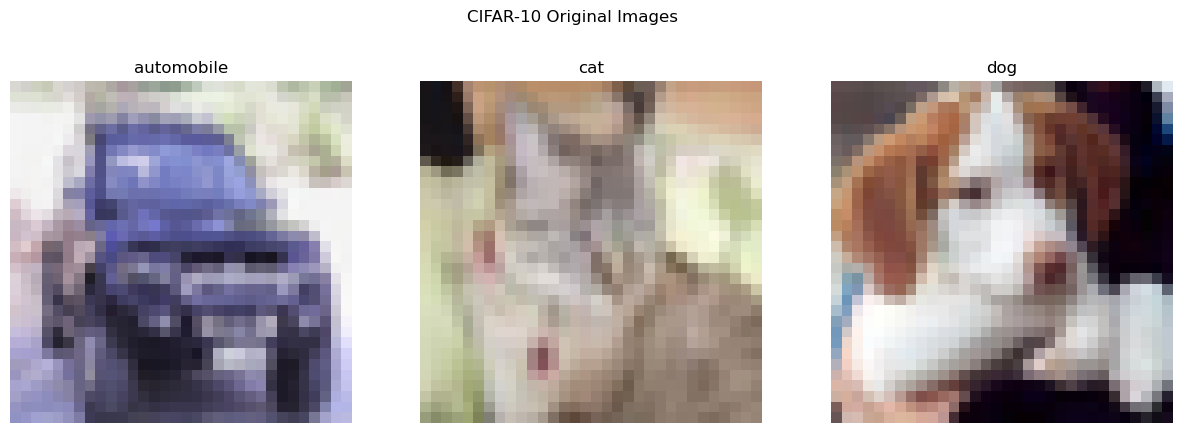

In [111]:

for test_images, test_labels in test_dataloader:
    show_images(test_images, test_labels, title="CIFAR-10 Original Images")  
    break
plt.show()

1/5th Time Epoch: 1/30

train_loss 0.05046792361704285
test_loss: 0.04231397628406935
Time 22.870140314102173
SSIM 0.4217368624632872


1/5th Time Epoch: 2/30

train_loss 0.04130813832897359
test_loss: 0.03931171546065355
Time 21.755171298980713
SSIM 0.498743809853928


1/5th Time Epoch: 3/30

train_loss 0.03883116389327037
test_loss: 0.038461518674334394
Time 19.543354272842407
SSIM 0.5240472773962384


1/5th Time Epoch: 4/30

train_loss 0.03756324035089339
test_loss: 0.03698229421920414
Time 19.16111707687378
SSIM 0.5354564853861362


1/5th Time Epoch: 5/30

train_loss 0.036542794064563865
test_loss: 0.03632626762684388
Time 19.134291648864746
SSIM 0.5572584407239021


1/5th Time Epoch: 6/30

train_loss 0.035672842760753755
test_loss: 0.035185149151690395
Time 19.083013772964478
SSIM 0.5689079708690885


1/5th Time Epoch: 7/30

train_loss 0.035112875106427674
test_loss: 0.035310024513473995
Time 19.068113088607788
SSIM 0.5705914595459081


1/5th Time Epoch: 8/30

train_loss 0.034509782939005994
test_loss: 0.03467910232234605
Time 19.055273294448853
SSIM 0.580628259272515


1/5th Time Epoch: 9/30

train_loss 0.03417218369824807
test_loss: 0.03372718389087086
Time 19.01372194290161
SSIM 0.5915473450588274


1/5th Time Epoch: 10/30

train_loss 0.03363721793436486
test_loss: 0.03407402030086216
Time 19.004063844680786
SSIM 0.5845886121822309


1/5th Time Epoch: 11/30

train_loss 0.03333439890895506
test_loss: 0.03427144109353989
Time 19.059961795806885
SSIM 0.5939414305023


1/5th Time Epoch: 12/30

train_loss 0.032868888486376806
test_loss: 0.033470784066410006
Time 19.092281818389893
SSIM 0.5982372504246386


1/5th Time Epoch: 13/30

train_loss 0.03250156971804626
test_loss: 0.03275197291676002
Time 19.05538058280945
SSIM 0.6082376882999758


1/5th Time Epoch: 14/30

train_loss 0.03222286980837355
test_loss: 0.03265098161712478
Time 19.033915281295776
SSIM 0.6035142722009104


1/5th Time Epoch: 15/30

train_loss 0.03191242490411567
test_loss: 0.032238455465700054
Time 19.06127405166626
SSIM 0.6106149011020419


1/5th Time Epoch: 16/30

train_loss 0.0315085607711845
test_loss: 0.03177313622134396
Time 19.34735083580017
SSIM 0.6193316239344923


1/5th Time Epoch: 17/30

train_loss 0.031362917126558934
test_loss: 0.03184668540577345
Time 19.226908922195435
SSIM 0.6187682347961619


1/5th Time Epoch: 18/30

train_loss 0.030990915263400358
test_loss: 0.03155675065951257
Time 19.147018432617188
SSIM 0.622081268437301


1/5th Time Epoch: 19/30

train_loss 0.03064177624519219
test_loss: 0.031189057032895994
Time 19.299058198928833
SSIM 0.6243357605571989


1/5th Time Epoch: 20/30

train_loss 0.03053938107245871
test_loss: 0.03085302019232436
Time 18.93965768814087
SSIM 0.629791424244265


1/5th Time Epoch: 21/30

train_loss 0.03020803571280921
test_loss: 0.030809876119977313
Time 18.970096349716187
SSIM 0.63226637281949


1/5th Time Epoch: 22/30

train_loss 0.03011508584213074
test_loss: 0.03056025512139254
Time 19.0541672706604
SSIM 0.6362964103493509


1/5th Time Epoch: 23/30

train_loss 0.02977106710681525
test_loss: 0.031109468775648106
Time 19.48349404335022
SSIM 0.6338969936853722


1/5th Time Epoch: 24/30

train_loss 0.029552863267681483
test_loss: 0.0298644420749779
Time 19.15261435508728
SSIM 0.6436467525325243


1/5th Time Epoch: 25/30

train_loss 0.0292859951181866
test_loss: 0.03016167801297918
Time 19.378458499908447
SSIM 0.6424269532855553


1/5th Time Epoch: 26/30

train_loss 0.029193726270590598
test_loss: 0.029591810618397555
Time 19.712661027908325
SSIM 0.6501476900487007


1/5th Time Epoch: 27/30

train_loss 0.028957103934053263
test_loss: 0.029731089579342288
Time 19.261319875717163
SSIM 0.6467775083795378


1/5th Time Epoch: 28/30

train_loss 0.028739135402738286
test_loss: 0.02995048692049105
Time 19.879539489746094
SSIM 0.6455928992621506


1/5th Time Epoch: 29/30

train_loss 0.028604104324146305
test_loss: 0.029266663862368727
Time 21.113648653030396
SSIM 0.6539441415026218
train_loss 0.02835595514387121
test_loss: 0.029698511019726342
Time 21.51720881462097
SSIM 0.6527173345602011
SSIM: 0.6527173345602011
loss_train: 0.0284,loss_test: 0.0297
MSE: 0.029698511019726342
ProcessingTime: 586.4742765426636


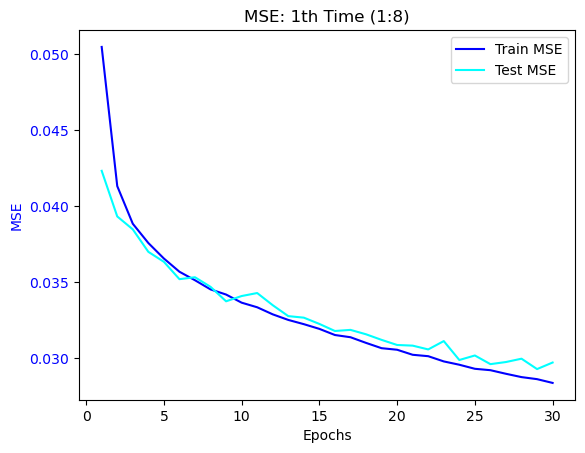

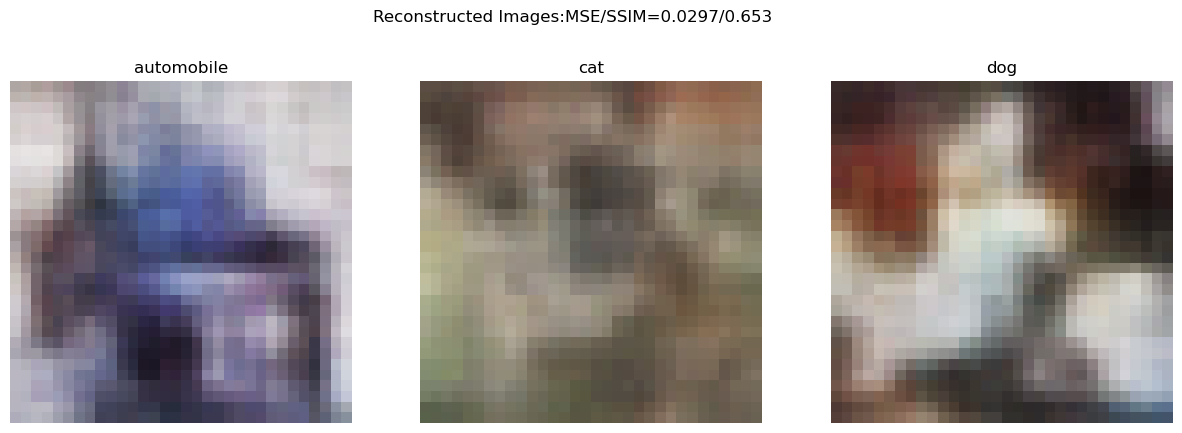

2/5th Time Epoch: 1/30

train_loss 0.04435315826321807
test_loss: 0.037388900695722316
Time 19.98110008239746
SSIM 0.5289445523219772


2/5th Time Epoch: 2/30

train_loss 0.03542686195191368
test_loss: 0.03381637528633015
Time 21.097397804260254
SSIM 0.578444034992894


2/5th Time Epoch: 3/30

train_loss 0.03313616072506551
test_loss: 0.032239589109262334
Time 21.914380311965942
SSIM 0.6025851263275629


2/5th Time Epoch: 4/30

train_loss 0.03170464721405902
test_loss: 0.03203482235062726
Time 21.93342399597168
SSIM 0.62269576063639


2/5th Time Epoch: 5/30

train_loss 0.03066782668575911
test_loss: 0.030109978787883927
Time 22.01717495918274
SSIM 0.6371411590636531


2/5th Time Epoch: 6/30

train_loss 0.02990265279207998
test_loss: 0.030342246747658223
Time 21.894055128097534
SSIM 0.6420766711235046


2/5th Time Epoch: 7/30

train_loss 0.029185432988359496
test_loss: 0.029427963202889963
Time 21.639854431152344
SSIM 0.6467322993882095


2/5th Time Epoch: 8/30

train_loss 0.028635043255470293
test_loss: 0.02898131801357752
Time 22.18010926246643
SSIM 0.6627940942969504


2/5th Time Epoch: 9/30

train_loss 0.02827544822869703
test_loss: 0.02813612910199769
Time 22.07028579711914
SSIM 0.6640121204943596


2/5th Time Epoch: 10/30

train_loss 0.027757593937923233
test_loss: 0.027378331563329396
Time 22.96757984161377
SSIM 0.6759960304332685


2/5th Time Epoch: 11/30

train_loss 0.0273485963168504
test_loss: 0.02759203522265712
Time 22.19183921813965
SSIM 0.6783818300766281


2/5th Time Epoch: 12/30

train_loss 0.02698451667414297
test_loss: 0.026978749192402333
Time 22.983010053634644
SSIM 0.6848631410659114


2/5th Time Epoch: 13/30

train_loss 0.026672088452960218
test_loss: 0.02773045232118685
Time 23.81888246536255
SSIM 0.6810922909386551


2/5th Time Epoch: 14/30

train_loss 0.026420745898581222
test_loss: 0.0268111213145754
Time 21.674192190170288
SSIM 0.6901298052147974


2/5th Time Epoch: 15/30

train_loss 0.026144137929963028
test_loss: 0.027142490177780768
Time 22.374662160873413
SSIM 0.6896580963195125


2/5th Time Epoch: 16/30

train_loss 0.025854628361628183
test_loss: 0.026705209849567355
Time 22.086687803268433
SSIM 0.6890556646298759


2/5th Time Epoch: 17/30

train_loss 0.025543448812973775
test_loss: 0.026218843728869776
Time 21.913980960845947
SSIM 0.6919355196288869


2/5th Time Epoch: 18/30

train_loss 0.025351785785516206
test_loss: 0.026171734650866894
Time 22.233577966690063
SSIM 0.7022805440274975


2/5th Time Epoch: 19/30

train_loss 0.025112491706028923
test_loss: 0.025907546494014656
Time 22.20757746696472
SSIM 0.7015940169744854


2/5th Time Epoch: 20/30

train_loss 0.024864429002985015
test_loss: 0.025477281382566767
Time 22.522483110427856
SSIM 0.708488456810577


2/5th Time Epoch: 21/30

train_loss 0.02467967988565907
test_loss: 0.025784867756728884
Time 21.678778171539307
SSIM 0.6997845361504373


2/5th Time Epoch: 22/30

train_loss 0.024509708251794587
test_loss: 0.025500012915345687
Time 22.587655067443848
SSIM 0.70591189136988


2/5th Time Epoch: 23/30

train_loss 0.02429593323498888
test_loss: 0.02543510649871977
Time 22.608479738235474
SSIM 0.7112077942377404


2/5th Time Epoch: 24/30

train_loss 0.024081667732742743
test_loss: 0.025269511591973184
Time 22.12439727783203
SSIM 0.7122806921789918


2/5th Time Epoch: 25/30

train_loss 0.023903968293800988
test_loss: 0.025077252731293062
Time 21.92818570137024
SSIM 0.713423287566704


2/5th Time Epoch: 26/30

train_loss 0.0237441944849232
test_loss: 0.024690935176007355
Time 21.845978021621704
SSIM 0.7179940765417074


2/5th Time Epoch: 27/30

train_loss 0.023502778152332586
test_loss: 0.02509904020949255
Time 22.030566453933716
SSIM 0.7133585788026641


In [ ]:

img_size = 32
channels = 3

DofIN = channels*img_size**2 ##CIFAR10 32*32*3
leverage = 8 ##圧縮倍率
kernel_size = 4 #カーネルサイズ
ch = 64##64
pos_embed_dim = 8##16
max_epochs = 30#50

num_try = 5##5

All_last_loss = []
All_last_ssim = []
All_loss_test = []
All_pro_time = []


for num_times in range(num_try): 

    model = AutoEncoder(img_size,channels,kernel_size,leverage,ch,pos_embed_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    loss_train_ = []
    loss_test_ = []
    pro_time_ = []

            
    for epoch in range(max_epochs):

        sys.stderr.write('\r%d/%dth Time Epoch: %d/%d' % (num_times+1,num_try, epoch, max_epochs)) 
        sys.stderr.flush()

        loss_train = 0
        loss_test = 0
        ssim_test_0=0

        start_time1 = time.time()
        for (x,t) in train_dataloader:
                    
            x, t = x.to(device), t.to(device)
            y = model(x).to(device)

            loss = criterion(y, x.view(x.size(0), -1)) 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
       
        loss_train_avg = loss_train / len(train_dataloader)
        end_time1 = time.time()
        pro_time_.append(end_time1-start_time1)


        with torch.no_grad():
            for x, t in test_dataloader:
                x, t = x.to(device), t.to(device)
                y = model(x).to(device)
                loss = criterion(y, x.view(x.size(0), -1))
                ssim_test0 = ssim_loss(y.view(-1, channels, img_size, img_size).cpu().numpy().transpose(0, 2, 3, 1), 
                                  x.view(-1, channels, img_size, img_size).cpu().numpy().transpose(0, 2, 3, 1), 
                                  channel_axis=-1,data_range=1.0)
                loss_test += loss.item()
                ssim_test_0 += ssim_test0

        loss_test_avg = loss_test / len(test_dataloader)
        ssim_test_avg = ssim_test_0 / len(test_dataloader)
        
        print('train_loss',loss_train_avg)
        print('test_loss:',loss_test_avg)
        print('Time',end_time1-start_time1)
        print('SSIM',ssim_test_avg)
        #print('alpha',alpha)
        loss_train_.append(loss_train_avg)
        loss_test_.append(loss_test_avg)
        
        if epoch == max_epochs-1:
            All_loss_test.append(loss_test_)
            All_pro_time.append(sum(pro_time_)) 
            All_last_ssim.append(ssim_test_avg) 
    Last_loss_test = loss_test_[-1]
    All_last_loss.append(Last_loss_test)
    print('SSIM:',ssim_test_avg)
    print(f"loss_train: {loss_train_avg:.4f},loss_test: {loss_test_avg:.4f}")
    print("MSE:",Last_loss_test)
    print('ProcessingTime:',sum(pro_time_))

    fig, ax1 = plt.subplots()
    ax1.plot(range(1,len(loss_train_)+1), loss_train_, label="Train MSE", color = 'blue')
    ax1.plot(range(1,len(loss_test_)+1), loss_test_, label="Test MSE", color = 'cyan')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('MSE', color = 'blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend()

    title = 'MSE: %dth Time (1:%d)'%(num_times+1,leverage) #
    plt.title(title)
    file_name = '%d_%dth(1_%d)_mse.png'%(int(formatted_date),num_times+1,leverage)
    full_path = os.path.join(save_directory, file_name)
    plt.savefig(full_path, dpi=100, bbox_inches='tight')
    plt.show()

    with torch.no_grad():
        test_images = test_images.to(device)
        reconstructed_images = model(test_images)
        image_title = "Reconstructed Images:MSE/SSIM=%.4f/%.3f"%(Last_loss_test,ssim_test_avg)
        show_images(reconstructed_images.cpu(),test_labels, image_title)
        file_name = '%d_ReImage%dth(1_%d).png'%(int(formatted_date),num_times+1,leverage)
        full_path = os.path.join(save_directory, file_name)
        plt.savefig(full_path, dpi=100, bbox_inches='tight')
        plt.show()




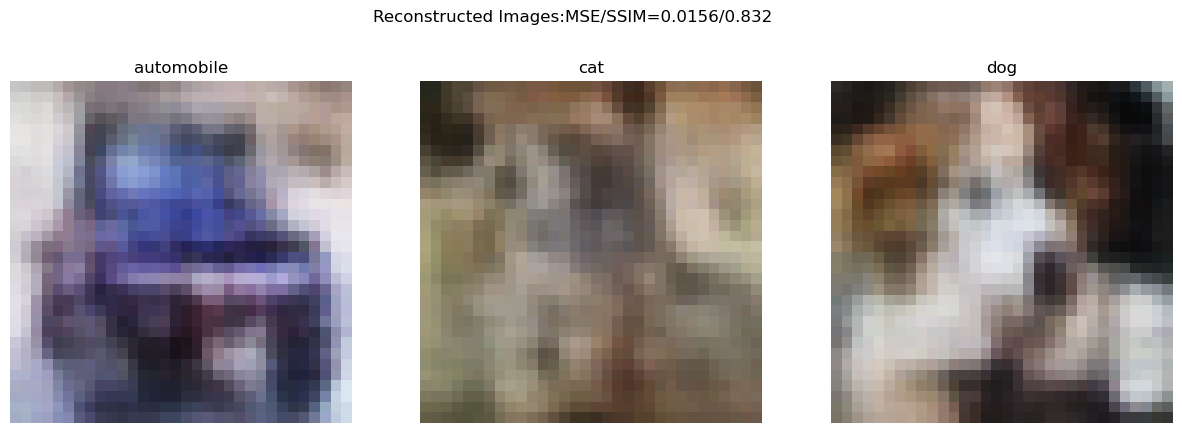

In [ ]:
with torch.no_grad():
    test_images = test_images.to(device)
    reconstructed_images = model(test_images)
    image_title = "Reconstructed Images:MSE/SSIM=%.4f/%.3f"%(Last_loss_test,ssim_test_avg)
    show_images(reconstructed_images.cpu(),test_labels, image_title)
    file_name = '%d_ReImage%dth(1_%d).png'%(int(formatted_date),num_times+1,leverage)
    full_path = os.path.join(save_directory, file_name)
    plt.savefig(full_path, dpi=100, bbox_inches='tight')
    plt.show()

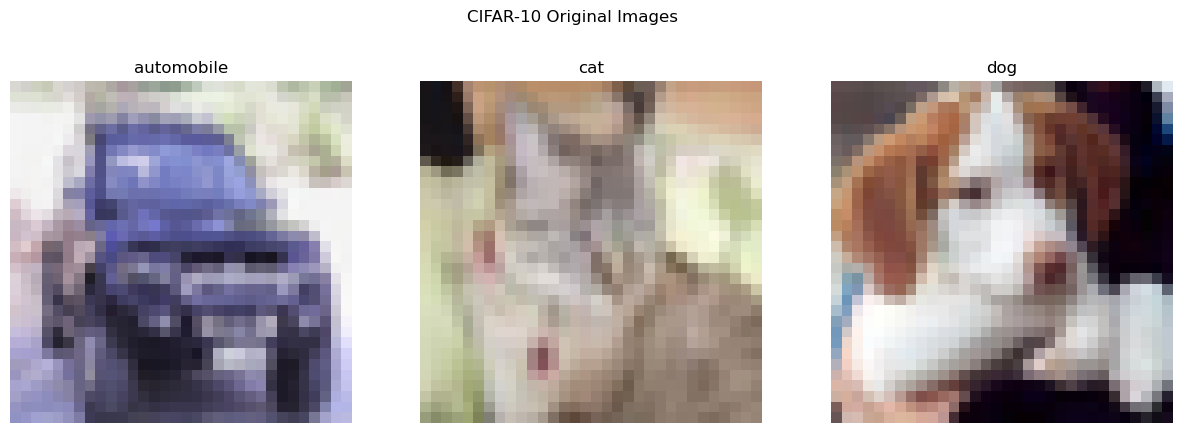

In [511]:
for test_images, test_labels in test_dataloader:
    show_images(test_images, test_labels, title="CIFAR-10 Original Images")             
    break
plt.show()

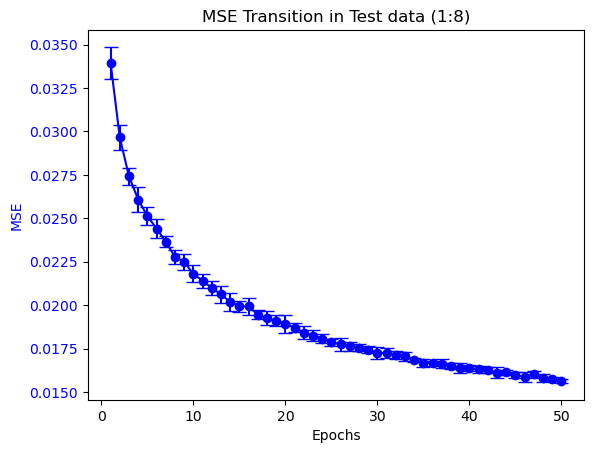

In [512]:
epochs = len(All_loss_test[0])  # エポック数（各リストの長さ）
num_dimensions = len(All_loss_test)  # 埋め込み次元数の数

# 各エポックごとに平均と標準偏差を計算
mean_loss = np.mean(All_loss_test, axis=0)
std_loss = np.std(All_loss_test, axis=0)

# グラフの描画
fig, ax1 = plt.subplots()

# 平均値の折れ線グラフと誤差範囲（標準偏差の誤差棒）
ax1.errorbar(
    x=range(1, epochs + 1), y=mean_loss, yerr=std_loss,
    fmt='-o', color='blue', ecolor='blue', capsize=5, 
)

# 軸ラベルやタイトルの設定
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.title('MSE Transition in Test data (1:%d)' % leverage)
file_name = '%d_MSE_errorbar.png'%(int(formatted_date))
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')

plt.show()

In [513]:
import csv
SSIM_mean = np.mean(All_last_ssim)
SSIM_best = np.max(All_last_ssim)
SSIM_bestID = np.argmax(All_last_ssim)+1
SSIM_worst = np.min(All_last_ssim)
SSIM_worstID = np.argmin(All_last_ssim)+1

MSE_mean = np.mean(All_last_loss)
MSE_best = np.min(All_last_loss)
MSE_bestID = np.argmin(All_last_loss)+1
MSE_worst = np.max(All_last_loss)
MSE_worstID = np.argmax(All_last_loss)+1

data = {
        "": ["SSIM", "MSE"],
    "Average": [SSIM_mean, MSE_mean],
    "Best ID": [SSIM_bestID, MSE_bestID],
    "Best": [SSIM_best, MSE_best],
    "Worst ID": [SSIM_worstID, MSE_worstID],
    "Worst": [SSIM_worst, MSE_worst],
}

df = pd.DataFrame(data)

print(df)

file_name = '%d_exTable.csv'%(int(formatted_date))
full_path = os.path.join(save_directory, file_name)
df.to_csv(full_path, index=False)

          Average  Best ID      Best  Worst ID     Worst
0  SSIM  0.832299        1  0.836801         4  0.829888
1   MSE  0.015649        1  0.015495         4  0.015859


In [514]:
pro_time_mean = sum(All_pro_time)/len(All_pro_time)
data2 = {
    "Index": list(range(1, len(All_pro_time) + 1)),  # インデックス（1から開始）
    "Processing Time": All_pro_time                # 各処理時間
}

df2 = pd.DataFrame(data2)
df2.loc[""] = ["Average", pro_time_mean]

print(df2)

     Index  Processing Time
0        1      1218.589702
1        2      1208.633667
2        3      1208.428414
3        4      1147.320108
4        5      1141.117693
   Average      1184.817917


In [515]:
import csv
save_directory1 = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoEncoder_data005','texts') 
print(save_directory1)
os.makedirs(save_directory1, exist_ok=True)
file_name = 'CIFAR10_NL1-8_list.csv'##
full_path = os.path.join(save_directory1, file_name)
with open(full_path, mode='w', newline='') as file:
    writer = csv.writer(file)

    writer.writerow(All_loss_test)

C:\Users\Scent\OneDrive\CODES\konishi_AutoEncoder\AutoEncoder_data005\texts
